In [18]:
!pip3 install --user findspark
import findspark
findspark.init()

In [19]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName("DMF").\
    getOrCreate()

In [3]:
!hdfs dfs -tail /DMF/DMF/ssdm1

             
 241527850BURDETTE                HOWARD                         0500197907271932                   
 241527855CALDWELL                DWIGHT                         0800198004161937                   
 241527858HUNT                    MILDRED        D              V0807200809051937                   
 241527859TARLTON                 DAVID          R              V0706201112231937                   
 241527861WATKINS                 MARY           A              V0806199903091919                   
 241527863HONEYCUTT               EUNICE         H              P0929201104051936                   
 241527865HOLLIS                  ENSLEY                         0700198610151935                   
 241527869THOMAS                  C                             V0115199303161938                   
 241527870WEST                    HARRIETT       K              V1216200902131937                   
 241527876DELLINGER               MARGIE         L              V111420111103

In [20]:
df1=spark.read.csv('/DMF/DMF/ssdm1')
df2=spark.read.csv('/DMF/DMF/ssdm2')
df3=spark.read.csv('/DMF/DMF/ssdm3')
df=df1.union(df2).union(df3)

In [5]:
df.show(10)

+--------------------+
|                 _c0|
+--------------------+
| 001010001MUZZEY ...|
| 001010009SMITH  ...|
| 001010010HAMMOND...|
| 001010011DREW   ...|
| 001010012CATE   ...|
| 001010013WHORFE ...|
| 001010015AMOS   ...|
| 001010016KUNCHO ...|
| 001010017MICHALS...|
| 001010019BODWELL...|
+--------------------+
only showing top 10 rows



In [21]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, to_date
import re

udf1 = udf(lambda x:x[0:1].strip(),StringType())
udf2 = udf(lambda x:x[1:10].strip(),StringType())
udf3 = udf(lambda x:x[10:30].strip(),StringType())
udf4 = udf(lambda x:x[30:34].strip(),StringType())
udf5 = udf(lambda x:x[34:49].strip(),StringType())
udf6 = udf(lambda x:x[49:64].strip(),StringType())
udf7 = udf(lambda x:x[64:65].strip(),StringType())
udf8 = udf(lambda x:re.sub("00(\d{4})",r'01\1',x[65:73].strip()),StringType())
udf9 = udf(lambda x:x[73:81].strip(),StringType())

df=df.withColumn('transaction_type',udf1('_c0'))\
    .withColumn('security_number',udf2('_c0'))\
    .withColumn('last_name',udf3('_c0'))\
    .withColumn('name_suffix',udf4('_c0'))\
    .withColumn('first_name',udf5('_c0'))\
    .withColumn('middle_name',udf6('_c0'))\
    .withColumn('V/P',udf7('_c0'))\
    .withColumn('death_date',to_date(udf8('_c0'),'MMddyyyy'))\
    .withColumn('birth_date',to_date(udf9('_c0'),'MMddyyyy'))\
    .drop('_c0')

In [7]:
df.limit(10).toPandas()

,transaction_type,security_number,last_name,name_suffix,first_name,middle_name,V/P,death_date,birth_date
0,,001010001,MUZZEY,,GRACE,,,1975-12-01,1902-04-16
1,,001010009,SMITH,,ROGER,,,1969-04-01,1892-02-04
2,,001010010,HAMMOND,,KENNETH,,,1976-03-01,1904-04-24
3,,001010011,DREW,,LEON,R,V,1987-08-30,1908-06-14
4,,001010012,CATE,,OLIVE,,,1981-09-01,1908-09-21
5,,001010013,WHORFE,,FRANK,,,1962-09-01,1888-04-06
6,,001010015,AMOS,,CHESTER,,,1984-02-01,1910-02-16
7,,001010016,KUNCHO,,DIMITRI,,,1981-03-01,1910-06-04
8,,001010017,MICHALS,,WILLIAM,,,1970-12-01,1907-11-07
9,,001010019,BODWELL,,MINNIE,,,1984-03-01,1895-04-05


In [54]:
df.select(df.transaction_type).distinct().count()


1

In [9]:
rowCount=df.count()

In [68]:
df=df.drop('transaction_type').withColumnRenamed("V/P","VP")

In [75]:
df.createOrReplaceTempView("DMF")
spark.sql("SELECT COUNT(*), VP FROM DMF\
    WHERE death_date is NULL\
    GROUP BY VP\
    ORDER BY COUNT(*) DESC").collect()

[Row(count(1)=40054147, VP=''),
 Row(count(1)=202039, VP='V'),
 Row(count(1)=2399, VP='P')]

In [10]:
df.where("death_date is NULL").count() / rowCount

1.4213253235173514e-05

In [90]:
from pyspark.sql.functions import year
df.where((df.birth_date != None) & (year(df.birth_date) > 2011)).count() / rowCount

0.0

In [91]:
df.where((df.death_date != None) & (year(df.death_date) > 2011)).count() / rowCount

0.0

In [10]:
from pyspark.sql.functions import month, max
df.agg(max(month(df.death_date))).collect()

[Row(max(month(death_date))=12)]

In [24]:
import re
print(re.sub("00(\d{4})",r'01\1',"19021900"))


19021900


In [16]:
df.summary().show()

+-------+----------------+--------------------+---------+-----------+--------------------+------------------+--------+
|summary|transaction_type|     security_number|last_name|name_suffix|          first_name|       middle_name|     V/P|
+-------+----------------+--------------------+---------+-----------+--------------------+------------------+--------+
|  count|        87735016|            87735016| 87735016|   87735016|            87735016|          87735016|87735016|
|   mean|            null|3.2454605701826423E8|     null|       null| 2.765166666666667E8| 1.915335463258786|    null|
| stddev|            null|1.6757388854785782E8|     null|       null|2.9333901984094167E8|1.8540821037063993|    null|
|    min|                |           001010001|         |           |                    |                  |        |
|    25%|            null|        1.96148997E8|     null|       null|                21.0|               0.0|    null|
|    50%|            null|        3.35424957E8| 

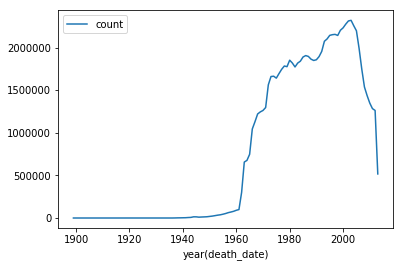

In [26]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year
df.groupBy(year(df.death_date)).count().orderBy('year(death_date)').toPandas().plot(x='year(death_date)',y='count')

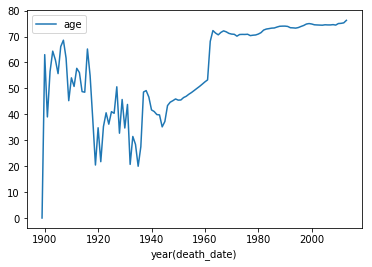

In [30]:
df.createOrReplaceTempView("DMF")
spark.sql("SELECT year(death_date),\
    avg(year(death_date)-year(birth_date)) as age\
    FROM DMF\
    GROUP BY year(death_date)\
    ORDER BY year(death_date)").toPandas()\
    .plot(x='year(death_date)',y='age')

In [27]:
df.groupBy(df.first_name).count() / df.count().orderBy('count',ascending=False).limit(5).show()
john_death = df.where(df.first_name == "JOHN").count() / df.count() * 100


# full = df.count()
# df.groupBy(df.first_name).count() 


# df
#   .groupBy(df.jirst_name)
#   .agg(sum("count").alias("count"))
#   .withColumn(df.first_name, col("count") /  sum("count").over())

0.02727578006026693

In [31]:
groupping = df.groupBy(df.first_name).count().orderBy('count',ascending=False).limit(5)
grouping.select('first_name','count', ((grouping['count']/ df.count())*100).alias('percent')).limit(5).show()

+----------+-------+------------------+
|first_name|  count|           percent|
+----------+-------+------------------+
|      JOHN|2393041| 2.727578006026693|
|      MARY|1985966| 2.263595643499968|
|   WILLIAM|1970477|2.2459413468392144|
|     JAMES|1749077|1.9935905636581863|
|    ROBERT|1481577|1.6886951955419942|
+----------+-------+------------------+



In [ ]:
grouping=df.groupBy(df.first_name).count().orderBy('count',ascending=False)

In [7]:
df.select(df.first_name).distinct().count()

741542

In [20]:
df.groupBy(df.first_name).count().orderBy('count').limit(5).show()

+----------+-----+
|first_name|count|
+----------+-----+
|      CAZL|    1|
|M A MADELE|    1|
|     PILOS|    1|
|   MYSIANA|    1|
|JOHN RIPLE|    1|
+----------+-----+



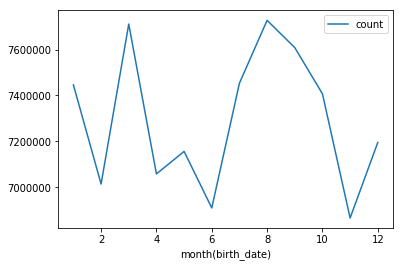

In [22]:
from pyspark.sql.functions import month
df.groupBy(month(df.birth_date))\
    .count()\
    .orderBy('month(birth_date)')\
    .toPandas()\
    .plot(x='month(birth_date)',y='count')

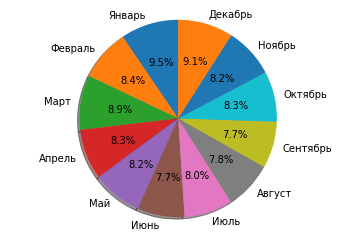

In [19]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes=df.groupBy(month(df.death_date))\
    .count()\
    .orderBy('month(death_date)')\
    .toPandas()['count']
labels='Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь','Июль','Август', 'Сентябрь', 'Октябрь','Ноябрь','Декабрь'
ax1.pie(sizes[1:], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()